# Exercise Set 13: Network formation

In this Exercise Set 13 we will investigate network formation among high school pupils. 

## Part 1: Network formation


Load the data using the script below. Read a bit about the dataset [here](http://www.sociopatterns.org/datasets/high-school-contact-and-friendship-networks/) to get an understanding of what is in each variable. 

The script gives you two dataframes to work with: 
 > `el`, which is an edge-list 
 >
 > `ind` which contains individual characteristics

In [2]:
import networkx as nx
import numpy as np
import pandas as pd

url_base = 'http://www.sociopatterns.org/wp-content/uploads/2015/'

# edgelist
url_el = url_base + '07/High-School_data_2013.csv.gz'
col_names_el = ['timestamp', 'u1', 'u2', 'class1', 'class2']
el = pd.read_csv(url_el, header=None, names=col_names_el, delimiter=' ')

# individual characteristics
url_ind = url_base + '09/metadata_2013.txt'
col_names_ind = ['u', 'class', 'gender']
ind = pd.read_csv(url_ind, header=None, names=col_names_ind, delimiter='\t')\
            .set_index('u')

# remove observation with missing gender
has_gender = ind[ind.gender!='Unknown'].index

# DataFrames
ind = ind.loc[has_gender].copy()
el = el[el.u1.isin(has_gender) &  el.u2.isin(has_gender)].copy()

> **Ex. 13.1.1**: Describe the edgelist columns content. Parse the timestamp. What is the resolution of meetings? Use the parsed timestamp to count the meetings by hour in local time.

In [3]:
# [Answer to ex. 13.1.1 here]

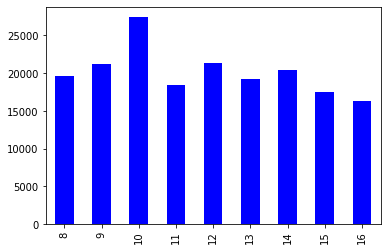

In [4]:
el['time'] = \
    pd.to_datetime(el.timestamp,unit='s')\
        .dt.tz_localize('UTC')\
        .dt.tz_convert('Europe/Paris')

%matplotlib inline
el.time.dt.hour.value_counts().sort_index().plot(kind='bar', color='blue')

> **Ex. 13.1.2**: Count the number of meetings for each edge and save this as a DataFrame called `el_agg`. Filter out edges with less than 5 minutes of meetings. Attach the gender and class of both nodes.

In [5]:
# [Answer to ex. 13.1.2 here]

In [6]:
el_agg =  el\
        .groupby(['u1', 'u2'])\
        .size()\
        .rename('meet_count')\
        .pipe(lambda s: s[s>=15])\
        .reset_index()

# Note: Look up the pipe function. (it borrows from a design idiom in R)

for u in '1', '2':
    for v in 'class', 'gender':        
        s = el_agg['u'+u].map(ind[v])
        el_agg[v+u] = s

> **Ex. 13.1.3**: Answer question in the function `fraction_triangles` below. Explain how `fraction_triangles` is related to  computing the clustering coefficient (using `nx.average_clustering`).
>
>> *Hint:* The following code does the same thing as `fraction_triangles`, but at a scale where you can understand what's going on. If you have a hard time understanding the code in the function you can try to play around with this simpler example
>>
>> ```python
>> import networkx as nx 
>>
>> A  = np.array(
>>     [[0, 1, 1, 0],
>>      [1, 0, 1, 0],
>>      [1, 1, 0, 1],
>>      [0, 0, 1, 0]]
>> )
>>
>> G = nx.from_numpy_array(A)
>> nx.draw(G,with_labels=True)
>>
>> def nth(A, n):
>>     A_ = A.copy()    
>>     for _ in range(1,n):
>>         A = A.dot(A_)
>>     return A
>>
>> a_t = nth(A,3).diagonal().sum()/6
>> n = len(A[:,0])
>> p_t = binom(n, 3)
>> ```


In [7]:
def make_net(el_, nodes):
    '''
    Convert edgelist to networkx graph which is 
    binary and undirected.
    
    Parameters
    ----------
    el_ : DataFrame
        Table containing an edgelist with columns 
        `u1` and `u2` which are the nodes in the edge.
        
    nodes : array-like
        1d array containing the node identities.
    '''    
    
    nx_input = el_, 'u1', 'u2', 'meet_count', nx.Graph()
    g = nx.from_pandas_edgelist(*nx_input)
    g.add_nodes_from(nodes)
    return g

In [8]:
from scipy.special import binom

def fraction_triangles(el_, nodes):
    '''
    Compute fraction of actual triangles out 
    of the potential triangles.
    
    Parameters
    ----------
    el_ : DataFrame
        Table containing an edgelist with columns 
        `u1` and `u2` which are the nodes in the edge.
        
    nodes : array-like
        1d array containing the node identities.
    '''
    
    g = make_net(el_, nodes)
    
    #Q.1: what is `A`?: the adjacency matrix which is symmetric and binary
    #Q.2: what does `A**3` do? compute the number of paths between two nodes
    #Q.3: what is diagonal of A_t? the number of actual paths of length 3, 
    # i.e. triangles, which include the person. these are called cycles
    # because they start and end at the same person
    
    # count actual triangles    
    A = nx.to_scipy_sparse_matrix(g)
    A_t = A**3
    a_t = A_t.diagonal().sum()/6
    
    #Q.4: what does `binom(n,3)` compute? the number of triangles including the person
    
    # count potential triangles
    n = len(g.nodes())
    p_t = binom(n, 3)
        
    return a_t/p_t

> **Ex. 13.1.4**: Apply the function `fraction_triangles` to `el_agg` and print the triangle fraction in the network. Next remove all edges that go between classes. Compute triangle fraction within each class and store it. Compute the mean within class triangles and bootstrap the standard error of the mean. Comment on the output.
>
>> *Hint:* To bootstrap an estimate draw $k>>0$ samples with replacement from the data. Compute the estimate on each of these samples and average them in the end to get the bootstrapped estimate. 

In [10]:
# [Answer to ex. 13.1.4 here]

In [11]:
print('Overall mean', round(fraction_triangles(el_agg, ind.index),5),'\n')

el_agg_same = el_agg[el_agg.class1==el_agg.class2]


i_dict = dict(tuple(ind.groupby('class')))
el_dict = dict(tuple(el_agg_same.groupby('class1')))
classes = el_agg_same.class1.unique()

frac_t = []
for c in classes:          
    f = fraction_triangles(el_ = el_dict[c], 
                           nodes = i_dict[c].index)
    frac_t.append(f)
    
frac_t_arr = pd.Series(frac_t)    

print('Within class mean', round(frac_t_arr.mean(),5))
std = np.std([frac_t_arr.sample(frac=1,replace=True).mean() for _ in range(10000)])
print('Within class std. error of mean', round(std,5),'\n')

print('The rate of triangles within classes are much higher (> 50 times).',
      '\nThis makes sense because they share class room togeher.')


Overall mean 0.0003 

Within class mean 0.02211
Within class std. error of mean 0.00276 

The rate of triangles within classes are much higher (> 50 times). 
This makes sense because they share class room togeher.


Recall from class that we can define the following measures of homophily. We define **homophily index** inspired by [Currarini et al. (2009)](https://doi.org/10.2139/ssrn.1021650):
- share of edges that are same type: $H = \frac{s}{s+d}$
- possible range [0,1]


We define **baseline homophily** as: 
- We count fraction of potential edges in population of nodes which are same type:

\begin{equation}B=\frac{\sum_t\#potential(n_t)}{\#potential(n)}, \qquad \#potential(k)=\frac{k\cdot(k-1)}{2}\end{equation}

- Interpretation: Expected homophily from random link formation.     

We define **inbreeding homophily** as:      

\begin{equation}IH=\frac{H-B}{1-B}\end{equation}


> **Ex. 13.1.5**: Compute the inbreeding homophily for each class. Use the class measures to compute the mean. Use a bootstrap to compute whether there is inbreeding homophily.

In [12]:
# [Answer to ex. 13.1.5 here]

In [22]:
def edge_active_potential(el_, nodes):        
    a = el_.shape[0]    
    n_ = len(nodes)
    p = n_*(n_-1)/2
    return a, p


el_agg_same2 = el_agg_same[el_agg_same.gender1==el_agg_same.gender2]

el_dict2 = dict(tuple(el_agg_same2.groupby(['class1', 'gender1'])))
i_dict2 = dict(tuple(ind.groupby(['class', 'gender'])))

H = pd.Series(np.zeros(9))
B = pd.Series(np.zeros(9))

for i, c in enumerate(classes):     
    
    a_all, p_all = edge_active_potential(el_dict[c], i_dict[c])    
    
    
    p_same, a_same = 0, 0 
    for g in 'M', 'F':
        a_same_, p_same_ = \
            edge_active_potential(el_dict2[(c,g)], i_dict2[(c,g)])
        
        p_same += p_same_
        a_same += a_same_
    H[i] = a_same/a_all
    B[i] = p_same/p_all
    
        
inbreed = (H-B)/(1-B)

print('Within class mean', round(inbreed.mean(),4))
test = 1-np.mean([inbreed.sample(frac=1,replace=True).mean()>0 for _ in range(10000)])
print('Test for gender inbreeding homophily, reject null with p=', round(test,4),'\n')

Within class mean 0.1105
Test for gender inbreeding homophily, reject null with p= 0.0 



> **Ex. 13.1.6** (BONUS): Describe what an unsupported edge is. Construct a test of whether there is a preference for forming  triangles within same gender than across.
>
>> *Hint:*  You can find inspiration in the approach of [Chandrasekhar, Jackson (2018)](https://web.stanford.edu/~arungc/CJ_sugm.pdf) pp. 31-35. They construct an almost identical test for triangle formation across castes in Indian villages.

In [ ]:
# [Answer to ex. 13.1.6 here]